In [75]:
import numpy as np
import math
# Module to display T/F matrix
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# Module for Unit testing
import pytest
# Module for convolutionnal decoder
import sk_dsp_comm.fec_conv as fec

In [76]:
my_data = np.genfromtxt('./tfMatrix.csv', delimiter=';')
mat_complex = my_data[:,0::2] +1j*my_data[:,1::2]

print(mat_complex.shape)

(14, 1024)


In [77]:
# --- Getting allocated subcarriers
tfMatrix_short = np.hstack((mat_complex[:,1:314], mat_complex[:,713:1024]))

print(tfMatrix_short.shape)

(14, 624)


In [78]:
def powerDistributionGraph(Z):
    """
    20Draw the power distribution graph
    """
    fig, ax = plt.subplots()
    cs = ax.contourf(np.linspace(0, len(Z[0]), len(Z[0])), np.linspace(0,
    len(Z), len(Z)), np.abs(Z))
    cbar = fig.colorbar(cs)
    ax.set_title('Power distribution')
    ax.set_xlabel('subcarriers')
    ax.set_ylabel('symbols')

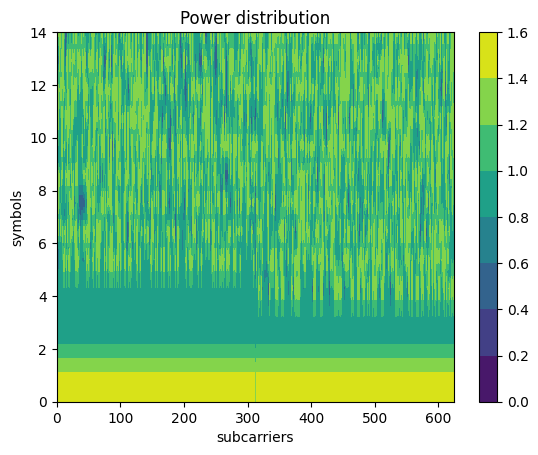

In [79]:
powerDistributionGraph(tfMatrix_short)

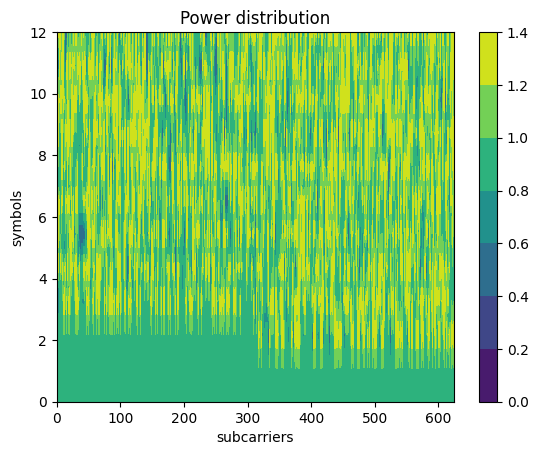

In [80]:
# --- Removing PSCH and SSCH channels
qamMatrix = tfMatrix_short[2:,:]

powerDistributionGraph(qamMatrix)

# PBCH Decoding

In [81]:
qamMatrix[0,0]

(-1+0j)

The value of a 2-QAM symbol is either 1 or -1, so the first symbol do is a 2-QAM symbol

In [90]:
def bpsk_demod(qamStream):
    """
    BPSK demodulation
    Convert a qamStream into a bitStream
    """
    out = []
    for x in qamStream:
        out.append(1 if x.real > 0 else 0)
    return out
        
print(qamMatrix[0,:10], bpsk_demod(qamMatrix[0,:10]))

[-1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j
  1.+0.j] [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


code testing

In [92]:
def test_bpsk():
    # BPSK decoding test
    assert bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0])) == [1, 1, 1, 0]
    assert bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0])) == [1, 1, 0, 1, 1, 1, 0, 1]
    assert bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0])) == [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
    assert bpsk_demod(np.array([-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0])) == [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
    assert bpsk_demod(np.array([-1.2+1j*-0.2,-0.9+1j*-0.3,-1.1+1j*0.1,-1.0+1j*-0.0,-0.8+1j*0.2,-1.1+1j*-0.0,1.0+1j*0.2,-1.0+1j*0.0,-1.0+1j*0.1,1.2+1j*0.1,1.1+1j*-0.1,-1.0+1j*-0.1,1.1+1j*-0.1,-1.0+1j*0.2,-0.8+1j*-0.1,-1.0+1j*0.1])) == [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]

test_bpsk()

In [94]:
extracted_info = qamMatrix[0,:49]

bpsk_demod(extracted_info)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0]

In [2]:
encoding_matrix =  [[1, 0, 0, 0, 0, 1, 1, 1],
                    [0, 1, 0, 0, 1, 0, 1, 1],
                    [0, 0, 1, 0, 1, 1, 0, 1],
                    [0, 0, 0, 1, 1, 1, 1, 0]]

decoding_matrix = [[0, 0, 0, 1, 1, 1, 1],
                   [0, 1, 1, 0, 0, 1, 1],
                   [1, 0, 1, 0, 1, 0, 1]]

def hamming748_decode(bitSeq):
    """
    Hamming 7,4,8 decoding
    """
    #Initialization of the sequence
    decoded_seq = ""

    # Loop over the bit sequence
    for i in range(0, len(bitSeq), 8):
        # Extract the current block
        block = bitSeq[i:i+7]

        #Calculate syndrome
        syndrome = []
        int_syndrome = 0

        # Compute the dot product of the bit sequence and the encoding matrix
        dot_product = np.dot(np.transpose(bitSeq), encoding_matrix)%2
        
        # Compute the syndrome
        syndrome = np.dot(decoding_matrix, dot_product)%2
        
        # Convert the syndrome to an integer
        for index in range(2,-1,-1):
            int_syndrome += syndrome[index]*(2**index)

        # Check if syndrome is non-zero
        if any(syndrome):
            # Check the parity bit
            if dot_product[0]%2 != 0:
                # Flip the bit
                block[int_syndrome] = (1 + block[int_syndrome])%2
            else:
                print("At least 2 Error detected")
        
        # Concatenate the decoded block to the sequence
        decoded_seq += "".join(map(str, block))
        
    return decoded_seq